In [1]:
cd ..

/Users/abrahamflamholz/Documents/workspace/tecantaloupe


In [2]:
%matplotlib inline
import seaborn

from growth.plate_spec import PlateSpec
from growth.plate_time_course_parser import SavageLabM1000Excel
from matplotlib import pyplot as plt

In [3]:
ps = PlateSpec.FromFile('growth/plate_specs/example_plate_spec_multimeasurement.csv')
name_mapping = ps.well_to_name_mapping()

# PlateSpec contains a DataFrame with all the names and
# stuff if you want to inspect.
ps.df

value_type          name                                              \
column                 1             2             3               4   
A              dCas9_0nM     dCas9_0nM     dCas9_0nM     No C2C2_0nM   
B              dCas9_2nM     dCas9_2nM     dCas9_2nM     No C2C2_2nM   
C             dCas9_20nM    dCas9_20nM    dCas9_20nM    No C2C2_20nM   
D           dCas9_2000nM  dCas9_2000nM  dCas9_2000nM  No C2C2_2000nM   
E               Sp02_0nM      Sp02_0nM      Sp02_0nM        Sp03_0nM   
F               Sp02_2nM      Sp02_2nM      Sp02_2nM        Sp03_2nM   
G              Sp02_20nM     Sp02_20nM     Sp02_20nM       Sp03_20nM   
H            Sp02_2000nM   Sp02_2000nM   Sp02_2000nM     Sp03_2000nM   

value_type                                                              \
column                   5               6             7             8   
A              No C2C2_0nM     No C2C2_0nM       NT _0nM       NT _0nM   
B              No C2C2_2nM     No C2C2_2nM       NT _2nM       NT _2nM   
C             No C2C2_20nM    No C2C2_20nM      NT _20nM      NT _20nM   
D           No C2C2_2000nM  No C2C2_2000nM    NT _2000nM    NT _2000nM   
E                 Sp03_0nM        Sp03_0nM     Sp04 _0nM     Sp04 _0nM   
F                 Sp03_2nM        Sp03_2nM     Sp04 _2nM     Sp04 _2nM   
G                Sp03_20nM       Sp03_20nM    Sp04 _20nM    Sp04 _20nM   
H              Sp03_2000nM     Sp03_2000nM  Sp04 _2000nM  Sp04 _2000nM   

value_type                                                          
column                 9            10            11            12  
A                NT _0nM      Sp01_0nM      Sp01_0nM      Sp01_0nM  
B                NT _2nM      Sp01_2nM      Sp01_2nM      Sp01_2nM  
C               NT _20nM     Sp01_20nM     Sp01_20nM     Sp01_20nM  
D             NT _2000nM   Sp01_2000nM   Sp01_2000nM   Sp01_2000nM  
E              Sp04 _0nM     Sp05 _0nM     Sp05 _0nM     Sp05 _0nM  
F              Sp04 _2nM     Sp05 _2nM     Sp05 _2nM     Sp05 _2nM  
G             Sp04 _20nM    Sp05 _20nM    Sp05 _20nM    Sp05 _20nM  
H           Sp04 _2000nM  Sp05 _2000nM  Sp05 _2000nM  Sp05 _2000nM

In [4]:
parser = SavageLabM1000Excel()
timecourse = parser.ParseFromFilename('growth/data/example_data_multimeasurement.xlsx')

# blanks by early measurements using default params.
# you can set blank_wells to blank by defined wells. 
blanked = timecourse.blank()
smoothed = blanked.smooth()

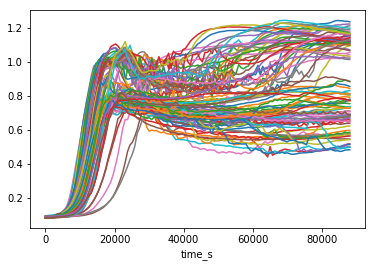

In [5]:
# Plot the raw absorbance data to see what's what. 
# Making sure everything grew.
# Note that we haven't averaged anything yet, so we will get one curve 
# for each well. A legend is pretty much useless for 96 curves...
timecourse.data_for_label('abs600').plot(x='time_s', legend=False)
plt.show()

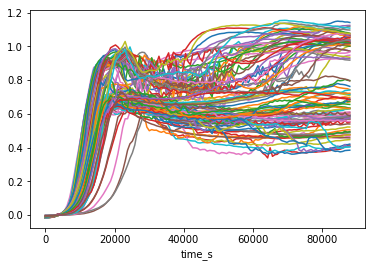

In [6]:
# blanking should make all the curves start at abs600 = 0.
blanked.data_for_label('abs600').plot(x='time_s', legend=False)
plt.show()

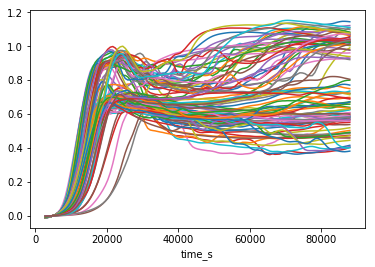

In [7]:
# Smoothed data is smoother, which helps when averaging or taking ratios.
smoothed.data_for_label('abs600').plot(x='time_s', legend=False)
plt.show()

In [8]:
# Get the mean and the standard error of the mean for the ratio.
mean_od = smoothed.mean_by_name(ps).data_for_label('abs600')
sem_od = smoothed.sem_by_name(ps).data_for_label('abs600')

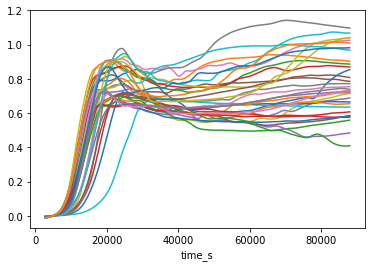

In [9]:
mean_od.plot(x='time_s', legend=False)
plt.show()

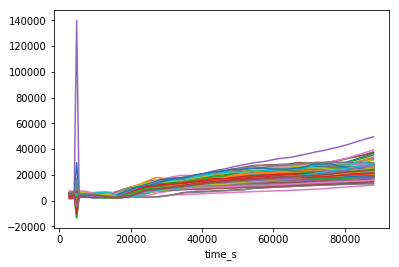

In [10]:
# Take the ratio GFP/abs600
gfp_per_od = smoothed.ratio_time_course('GFP', 'abs600')
gfp_per_od.data_for_label('GFP/abs600').plot(legend=False, x='time_s')

In [11]:
# Get the mean and the standard error of the mean for the ratio.
means = gfp_per_od.mean_by_name(ps).data_for_label('GFP/abs600')
sems = gfp_per_od.sem_by_name(ps).data_for_label('GFP/abs600')

/usr/local/lib/python3.6/site-packages/numpy/core/numeric.py:492: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


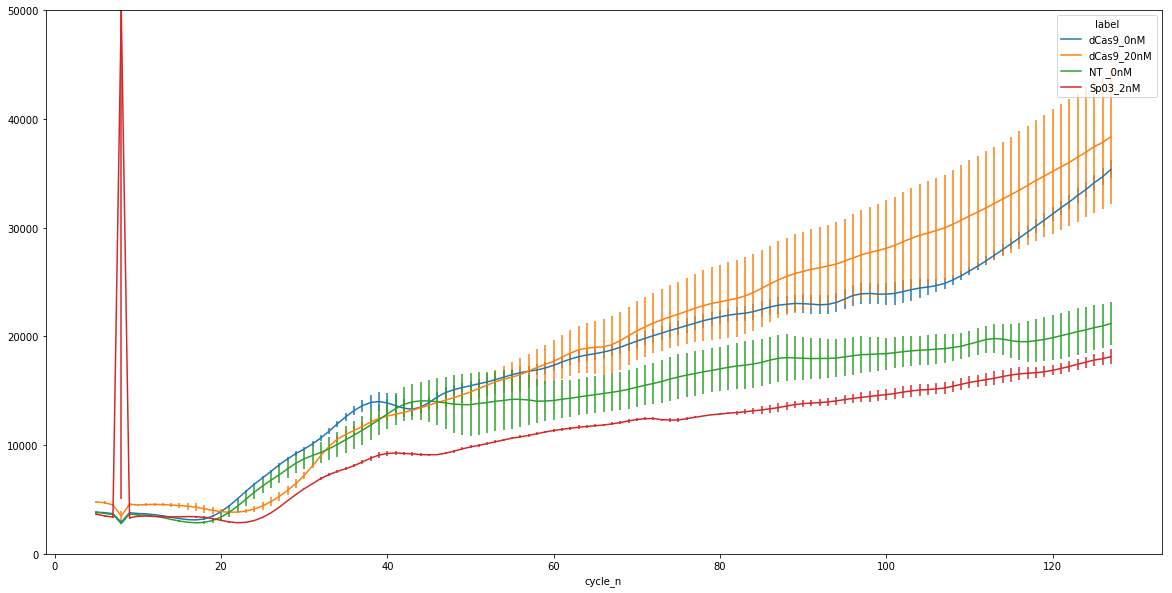

In [12]:
# plot a subset of the GFP/OD data - for only these four labels.
to_plot = ['dCas9_0nM', 'dCas9_20nM', 'NT _0nM', 'Sp03_2nM']
means[to_plot].plot(yerr=sems[to_plot], legend=True, figsize=(20,10), ylim=(0, 50000),)

In [13]:
# Now let's get the means for all the original data so we can plot GFP against RFP. 
all_means = smoothed.mean_by_name(ps)
GFP_mean = all_means.data_for_label('GFP')
RFP_mean = all_means.data_for_label('RFP')

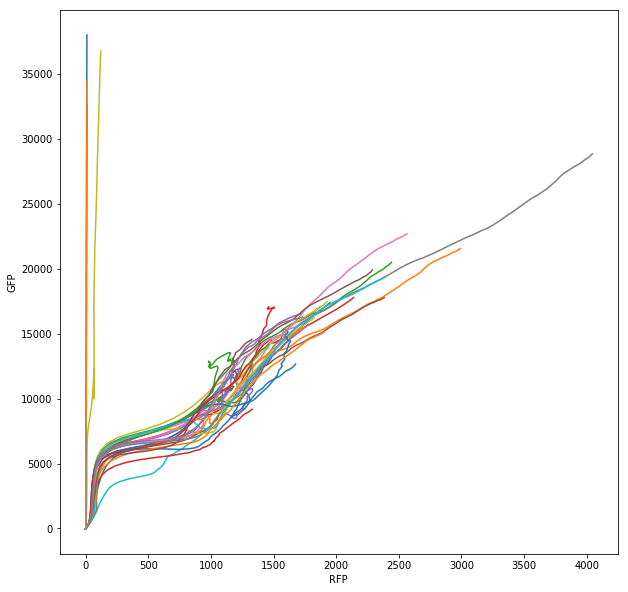

In [14]:
# I happen to know that the last column is the time column in both cases. 
# We don't want to plot time against time, so we only plot the other columns.
cols = GFP_mean.columns[:-1]

# Unfortunately you can't call plot on the RFP_mean or GFP_mean DataFrames for this.
# It doesn't seem to have the ability to plot DataFrames against each other... 
# So we need to use matplotlib directly.
figure = plt.figure(figsize=(10,10))
plt.plot(RFP_mean[cols], GFP_mean[cols])
plt.xlabel('RFP')
plt.ylabel('GFP')
plt.show()